In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

In [113]:
df = pd.read_csv('data/winequality-red.csv', sep=';')
df.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [114]:
# define os datasets necessarios
# monta a matriz X original
variables_df = df.drop(columns='quality')
col1 = np.ones(variables_df.shape[0])
col2 = variables_df.values

X_orig = np.column_stack((col1, col2))
y_orig = df['quality'].values

# monta a matriz X normalizada
col1 = np.ones(variables_df.shape[0])
col2 = variables_df.values

for col_idx, column in enumerate(variables_df.columns):
    col2[:, col_idx] = (col2[:, col_idx] - variables_df[column].mean()) / variables_df[column].std()

X_norm = np.column_stack((col1, col2))
y_norm = (df['quality'].values - df['quality'].mean()) / df['quality'].std()

n = X_orig.shape[0]
f = X_orig.shape[1]

print(n, f)

1599 12


In [115]:
# funções necessárias
def predict(X, theta):
  return X @ theta

def derivadas_regressao_media(theta, X, y):
  return -2 * ((y - X @ theta) @ X) / len(y)

def gd(X, y, lambda_=0.0001, tol=0.00001, max_iter=10000, regularization=10):
  n = X.shape[0]
  f = X.shape[1]

  theta = np.ones(f)
  old_err_sq = np.inf
  err_hist = []

  i = 0
  while True:
    # Computar as derivadas
    grad = derivadas_regressao_media(theta, X, y)
    # Atualizar
    theta_novo = theta - lambda_ * grad + regularization * (theta ** 2).sum()

    # Parar quando o erro convergir
    err_sq = ((X.dot(theta) - y) ** 2).mean()
    err_hist.append(err_sq)
    if np.abs(old_err_sq - err_sq) <= tol:
      break
    theta = theta_novo
    old_err_sq = err_sq
    #print('Iter {}; theta = '.format(i+1), theta)
    i += 1
    if i == max_iter:
      break

  return theta, err_hist

def convert_norm_to_orig(theta_norm, X_orig, y_orig):
    orig_theta = theta_norm
    for idx, coeff in enumerate(theta_norm):
        if idx == 0:
            # coeficiente linear, faz depois
            continue

        orig_theta[idx] = coeff * y_orig.std() / X_orig[:,idx].std()

    # corrige o linear
    sum_others = 0

    for j in range(1, f):
        sum_others += orig_theta[j] * X_orig[:,j].mean()
        
    orig_theta[0] = y_orig.mean() + y_orig.std() * theta_norm[0] - sum_others
    return orig_theta

def add_bias(X):
    return np.c_[np.ones(X.shape[0]), X]

Acc = 76.25 %


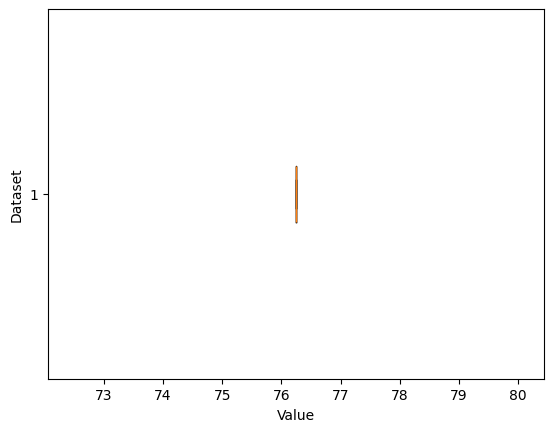

In [116]:
number_of_experiments = 1
acc_list = []
for exp in range(number_of_experiments):
    # regressão normalizada
    theta_norm, err_hist =  gd(X_norm, y_norm, max_iter=50000, regularization=0)
    orig_theta = convert_norm_to_orig(theta_norm, X_orig, y_orig)

    # ja separa eles originais
    X_train, X_test, y_train, y_test = train_test_split(X_orig, y_orig, test_size=0.3)

    # calcula acurácia: tem que acertar a qualidade em =/- 0.5 unidades
    TOLERANCE = 0.8

    # ve no conjunto de teste
    predictions = predict(X_test, orig_theta)

    correct = 0
    for i in range(len(y_test)):
        number = predictions[i]
        lower_bound = y_test[i]  -TOLERANCE
        upper_bound = y_test[i] + TOLERANCE
        if number >= lower_bound and number <= upper_bound:
            correct += 1
    
    acc = round(correct / len(y_test), 4) * 100
    print(f"Acc = {acc} %")
    acc_list.append(acc)

# Create the horizontal box plot
plt.boxplot(acc_list, vert=False)

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Dataset')

# Display the plot
plt.show()
